# Imports

In [1]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
import scvelo as scv
import scanpy as sc
import cellrank as cr

In [3]:
scv.settings.verbosity = 3
scv.settings.set_figure_params("scvelo")
cr.settings.verbosity = 2

# Load Data

In [4]:
rna_meta_ad = pickle.load(open("data/rna_meta_ad.p", "rb"))

# Index each metacell
rna_meta_ad.obs['metacell'] = range(99)

# Sort metacells
rna_meta_ad = rna_meta_ad[rna_meta_ad.obs.sort_values('celltype').index]

In [5]:
# Load in gene scores
gene_scores_df = pd.read_csv('data/cd34_gene_scores.csv', index_col=0)
gene_scores_df = gene_scores_df.loc[rna_meta_ad.obs.index]

In [6]:
# Add gene scores dataframe into metacell anndata object
rna_meta_ad.obsm['gene_scores'] = gene_scores_df

In [7]:
# PCA
sc.tl.pca(rna_meta_ad)

# Compute neighborhood graph
sc.pp.neighbors(rna_meta_ad, n_pcs=30, n_neighbors=18)

In [8]:
rna_meta_ad

AnnData object with n_obs × n_vars = 99 × 12464
    obs: 'celltype', 'metacell'
    uns: 'pca', 'neighbors'
    obsm: 'gene_scores', 'X_pca'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

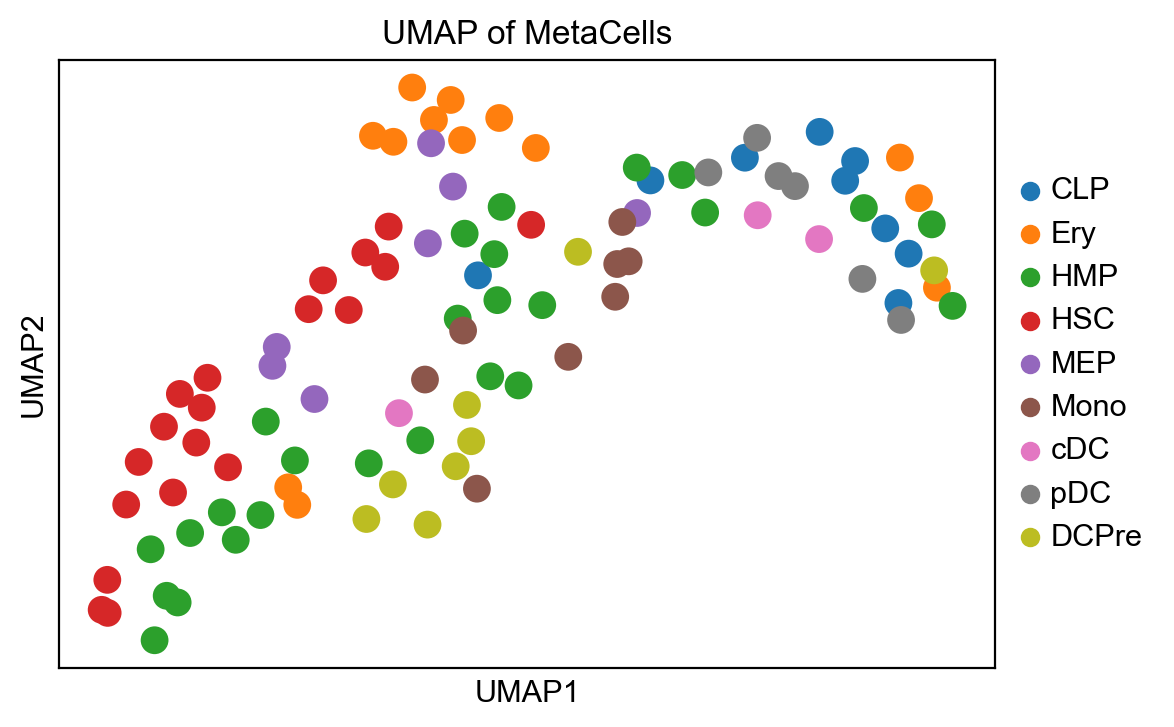

In [9]:
sc.tl.leiden(rna_meta_ad)
sc.tl.umap(rna_meta_ad)
sc.pl.umap(rna_meta_ad, color='celltype', size=400,
           title="UMAP of MetaCells")

# Cosine Similarity Kernel

In [10]:
from sklearn.metrics.pairwise import cosine_similarity
from anndata import AnnData
from typing import Any

In [11]:
class CosineSimilarityKernel(cr.tl.kernels.Kernel):
    def __init__(
        self, adata: AnnData, obs_key: str = "gene_scores", **kwargs: Any
    ):
        super().__init__(adata=adata, obs_key=obs_key, **kwargs)

    def _read_from_adata(self, obs_key: str, **kwargs: Any) -> None:
        super()._read_from_adata(**kwargs)
        self.gene_scores = self.adata.obsm[obs_key].values

    def compute_transition_matrix(self) -> "MyKernel":
        cosine_sim = cosine_similarity(self.gene_scores)
        self._compute_transition_matrix(cosine_sim, density_normalize=True)
        return self

    def copy(self) -> "CosineSimilarityKernel":
        return copy(self)

In [12]:
# Initialize CS Kernel
cs = CosineSimilarityKernel(rna_meta_ad).compute_transition_matrix()

In [13]:
cs

<CosineSimilarityKernel>

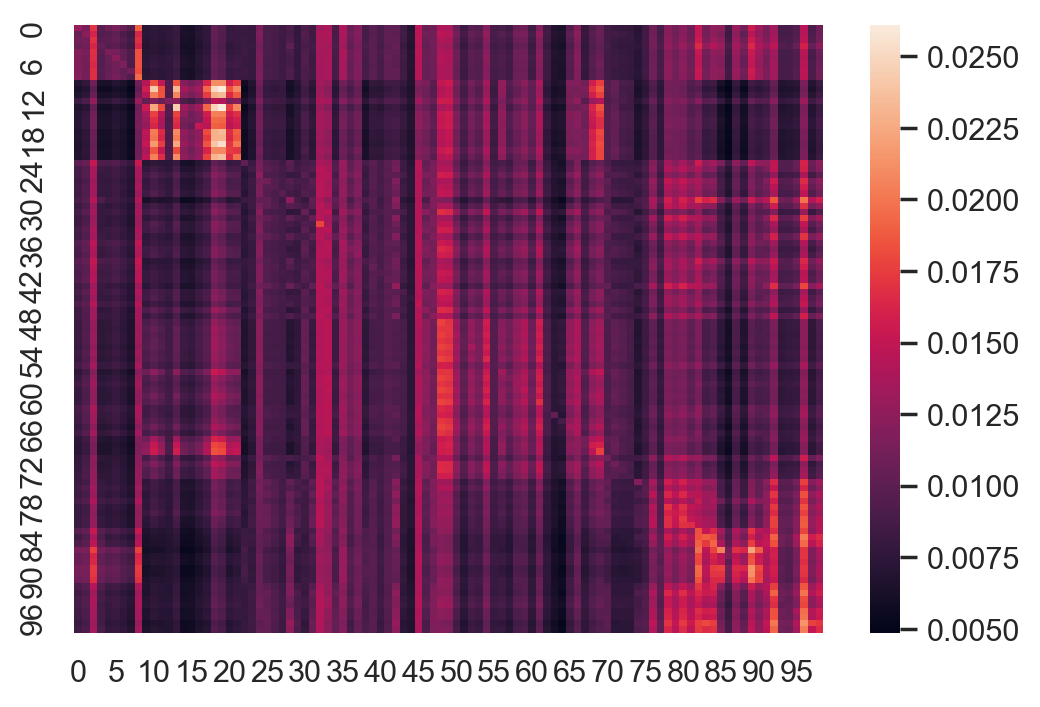

In [14]:
import seaborn as sns; sns.set_theme()

# Visualize transition matrix as a heatmap
ax = sns.heatmap(cs.transition_matrix)

# CellRank

In [15]:
from cellrank.tl.estimators import GPCCA

g = GPCCA(cs)
print(g)

GPCCA[n=99, kernel=<CosineSimilarityKernel>]


In [16]:
# Compute matrix decomposition
g.compute_schur(n_components=9)

# Compute macrostates
g.compute_macrostates(n_states=5, n_cells=10)

Computing Schur decomposition
Adding `adata.uns['eigendecomposition_fwd']`
       `.schur_vectors`
       `.schur_matrix`
       `.eigendecomposition`
    Finish (0:00:00)
Computing `5` macrostates
Adding `.macrostates`
       `.macrostates_memberships`
       `.coarse_T`
       `.coarse_initial_distribution
       `.coarse_stationary_distribution`
       `.schur_vectors`
       `.schur_matrix`
       `.eigendecomposition`
    Finish (0:00:00)


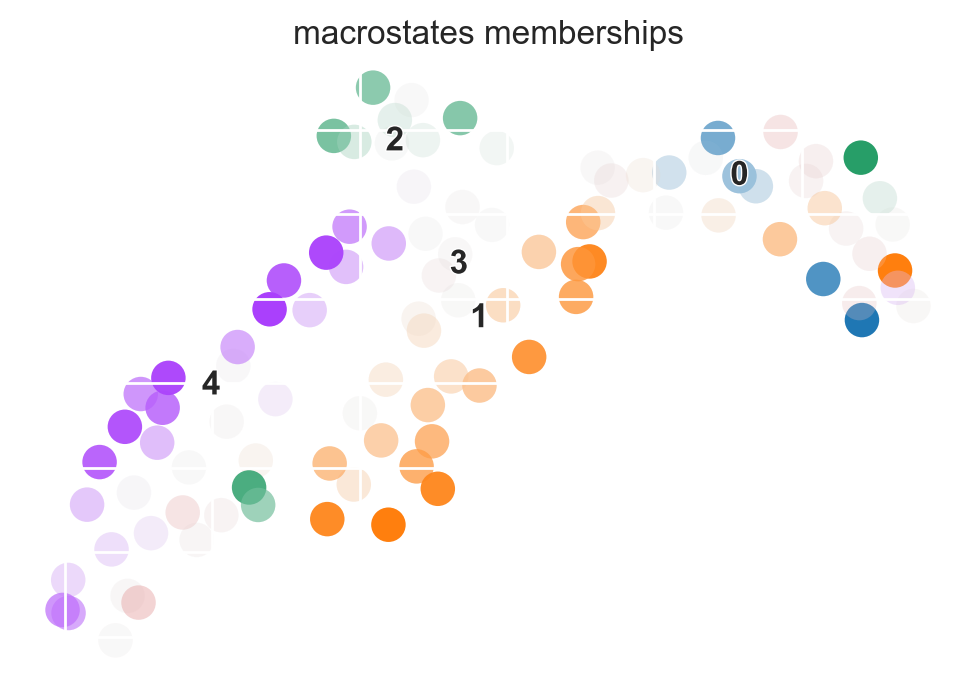

In [17]:
g.plot_macrostates()

/Users/eubinpark/opt/anaconda3/envs/seacells/lib/python3.8/site-packages/scvelo/plotting/utils.py:866: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cb = pl.colorbar(smp, orientation=orientation, cax=cax)


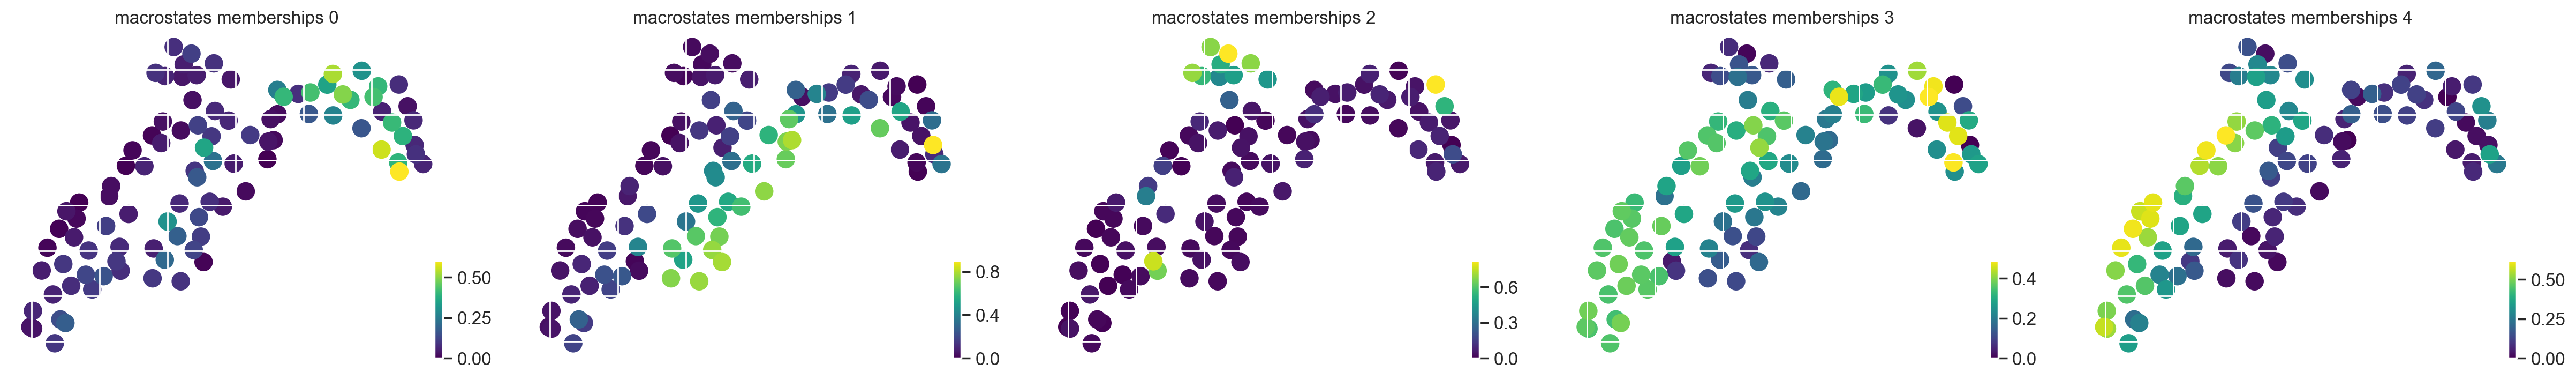

In [18]:
g.plot_macrostates(same_plot=False)

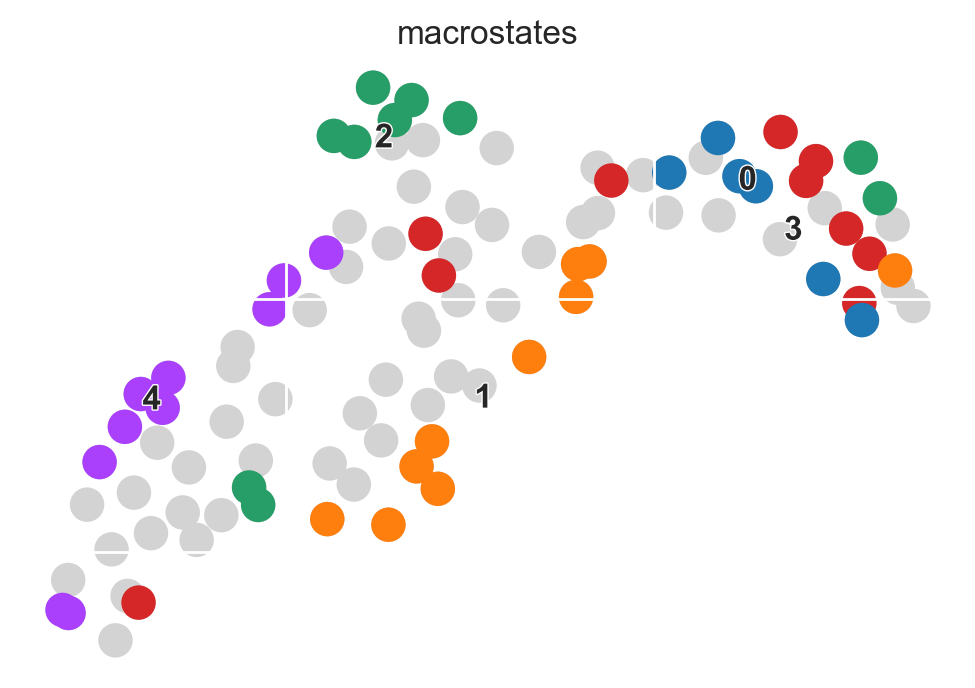

In [19]:
g.plot_macrostates(discrete=True)

/Users/eubinpark/opt/anaconda3/envs/seacells/lib/python3.8/site-packages/cellrank/tl/estimators/terminal_states/_gpcca.py:613: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  _ = ColorbarBase(


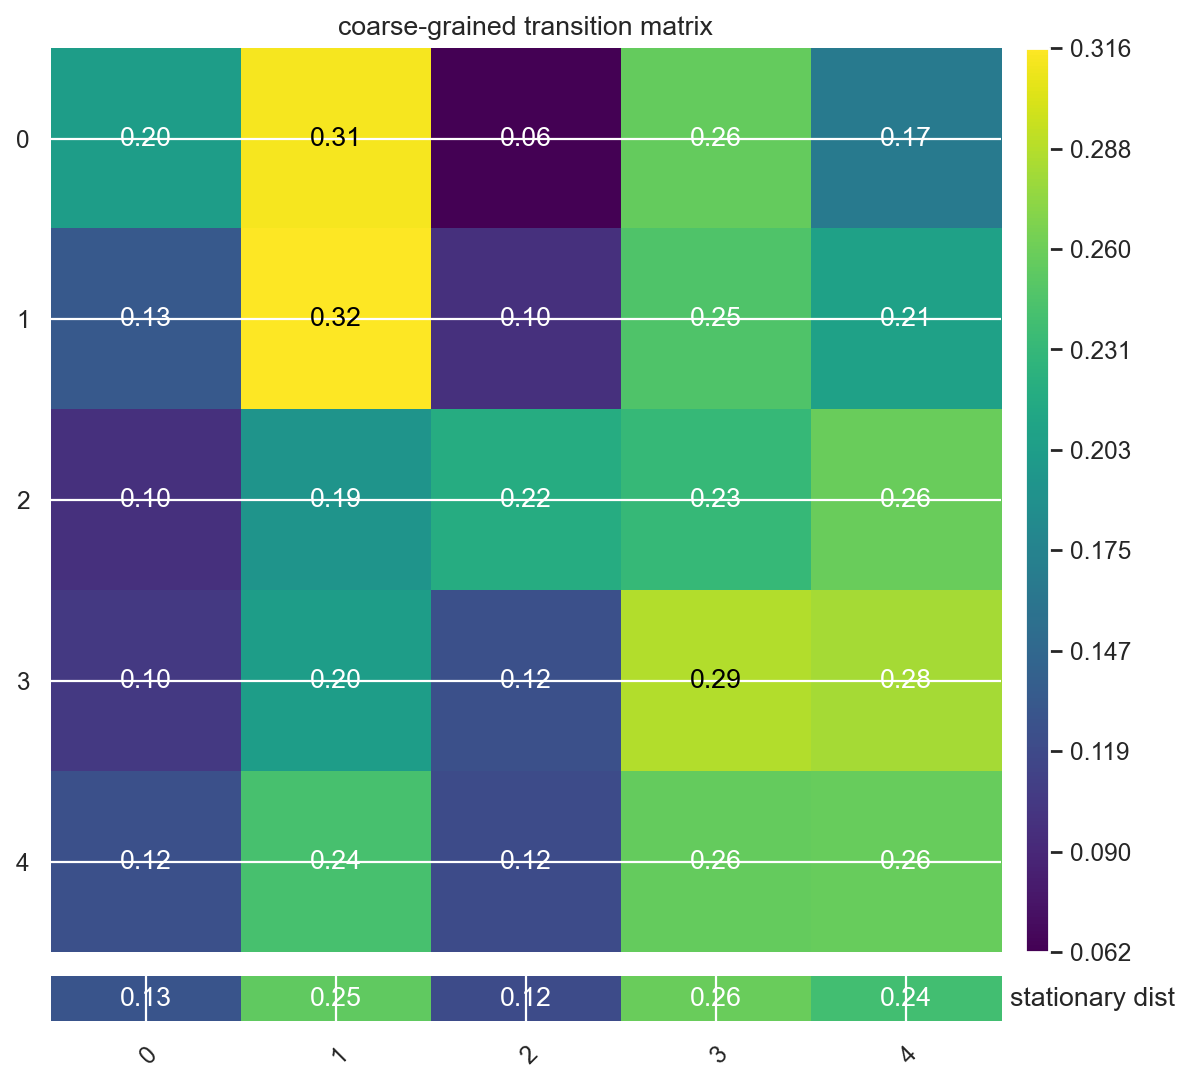

In [20]:
g.plot_coarse_T()

In [21]:
# Predict terminal states
g.predict(n_cells=10, stability_threshold=0.26)

Adding `adata.obs['terminal_states']`
       `adata.obs['terminal_states_probs']`
       `.terminal_states`
       `.terminal_states_probabilities`
       `.terminal_states_memberships
    Finish`


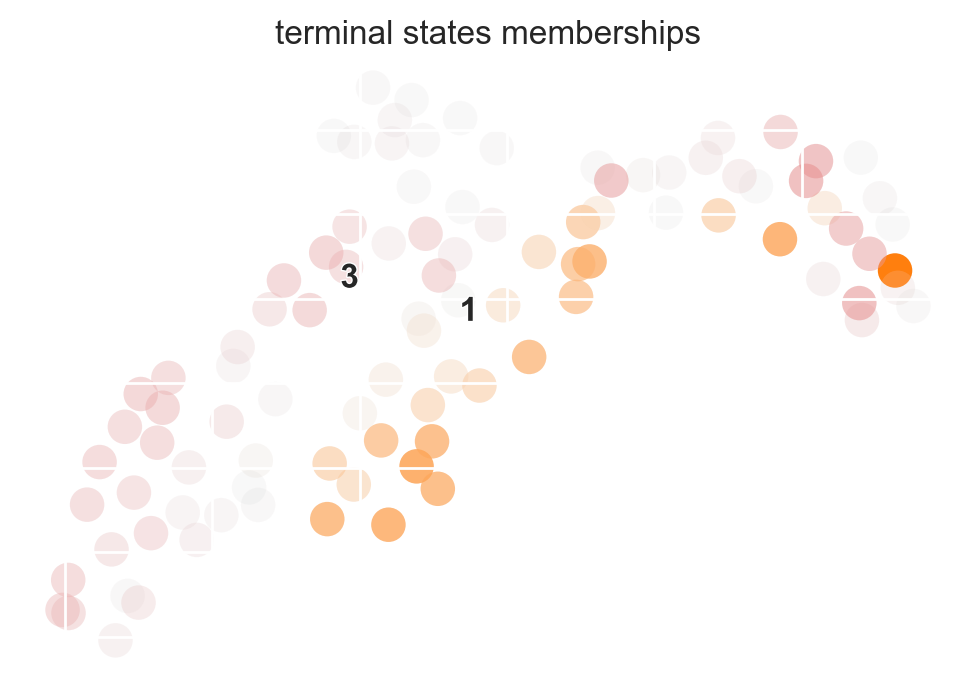

In [22]:
g.plot_terminal_states()